In [95]:
"""
Loads result to dataframe and analyzes the results
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from format_urls.load_results_to_dataframe import load_results_to_dataframe


notebook_dir = os.getcwd()

In [96]:
top_10k = load_results_to_dataframe(
    file_name="data/top-10000-pages-and-screens-30-days-doi-20241004.csv",
    notebook_dir=notebook_dir,
)

top_10k["url"] = top_10k.apply(
    lambda row: "https://" + str(row["domain"]) + str(row["pagePath"]), axis=1
)

top_10k.head(10000)

,page_title,domain,pagePath,pageviews,url
0,Latest Earthquakes,earthquake.usgs.gov,/earthquakes/map/,27374679,https://earthquake.usgs.gov/earthquakes/map/
1,Webcam (U.S. National Park Service),www.nps.gov,/media/webcam/view.htm,695020,https://www.nps.gov/media/webcam/view.htm
2,NPS.gov Homepage (U.S. National Park Service),www.nps.gov,/index.htm,651717,https://www.nps.gov/index.htm
3,EarthExplorer,earthexplorer.usgs.gov,/,557336,https://earthexplorer.usgs.gov/
4,U.S. Department of the Interior | Bureau of Indian Education,www.bie.edu,/,507242,https://www.bie.edu/
...,...,...,...,...,...
9995,Bike Carriage Roads (U.S. National Park Service),www.nps.gov,/thingstodo/bike-carriage-roads.htm,808,https://www.nps.gov/thingstodo/bike-carriage-roads.htm
9996,Boulder Bridge Hike (U.S. National Park Service),www.nps.gov,/thingstodo/boulder-bridge-hike.htm,808,https://www.nps.gov/thingstodo/boulder-bridge-hike.htm
9997,"Buffalo River Below Lobelville, TN - USGS Water Data for the Nation",waterdata.usgs.gov,/monitoring-location/03604400/,808,https://waterdata.usgs.gov/monitoring-location/03604400/
9998,Camping - Organ Pipe Cactus National Monument (U.S. National Park Service),www.nps.gov,/orpi/planyourvisit/camping.htm,808,https://www.nps.gov/orpi/planyourvisit/camping.htm


In [97]:
single_domain = pd.DataFrame(top_10k[top_10k["domain"] == "www.nps.gov"])

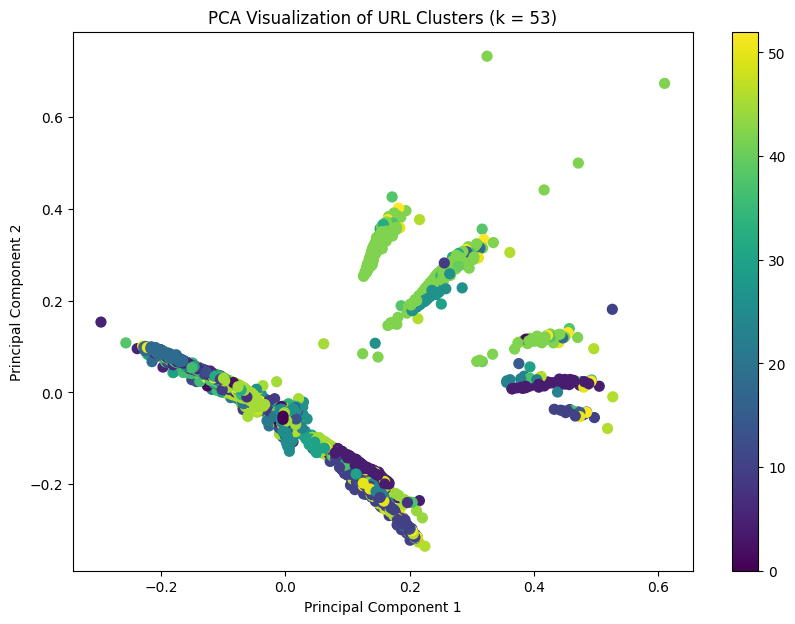

In [98]:
def extract_features(url):
    """
    Extract meaningful parts from the URL
    """
    parts = url.split("/")
    return " ".join([part for part in parts if part and not part.startswith("www.")])


def preprocess_urls(urls):
    """
    Preprocess URLs
    """
    return [extract_features(url) for url in urls]


def find_optimal_k(data, max_k):
    """
    Find the optimal number of clusters
    """
    silhouette_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)
    return silhouette_scores.index(max(silhouette_scores)) + 2


def cluster_urls(urls, max_k=100):
    """
    Cluster URLs
    """
    processed_urls = preprocess_urls(urls)

    # Create TF-IDF vectors
    vectorizer = TfidfVectorizer()
    x_matrix = vectorizer.fit_transform(processed_urls)

    # Find optimal number of clusters
    optimal_clusters = find_optimal_k(x_matrix, max_k)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    kmeans.fit(x_matrix)

    return x_matrix, kmeans.labels_, optimal_clusters


# URLs to be clustered
urls = single_domain["pagePath"].to_list()

# Perform clustering and get the TF-IDF matrix (X), cluster labels, and optimal_k
X, cluster_labels, optimal_k = cluster_urls(urls)

# Add cluster labels to the DataFrame
single_domain_with_clusters = single_domain.copy()
single_domain_with_clusters["cluster"] = cluster_labels

# Apply PCA to reduce the dimensionality to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Create a scatter plot of the PCA-transformed data
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap="viridis", s=50)
plt.colorbar(scatter)
plt.title(f"PCA Visualization of URL Clusters (k = {optimal_k})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [99]:
# Group by the 'cluster' column and calculate the total page views for each cluster
grouped = (
    single_domain_with_clusters.groupby("cluster")
    .agg({"pageviews": "sum"})
    .reset_index()
)

# Rename the columns for better readability
grouped.columns = ["cluster", "total_pageviews"]

# Sort the grouped dataframe by total pageviews in descending order
sorted_grouped = grouped.sort_values(by="total_pageviews", ascending=False)

# Display the total page views for each cluster in sorted order
pd.set_option("display.max_colwidth", None)

for cluster_id, total_pageviews in sorted_grouped.itertuples(index=False):
    print(f"Cluster {cluster_id}: {total_pageviews} total pageviews")

Cluster 45: 7063046 total pageviews
Cluster 42: 6064375 total pageviews
Cluster 29: 1188389 total pageviews
Cluster 36: 1169757 total pageviews
Cluster 5: 1088343 total pageviews
Cluster 52: 1061669 total pageviews
Cluster 38: 1057584 total pageviews
Cluster 4: 997674 total pageviews
Cluster 23: 980026 total pageviews
Cluster 26: 975675 total pageviews
Cluster 46: 895002 total pageviews
Cluster 18: 894265 total pageviews
Cluster 25: 871535 total pageviews
Cluster 19: 830039 total pageviews
Cluster 27: 688427 total pageviews
Cluster 30: 682995 total pageviews
Cluster 15: 625583 total pageviews
Cluster 10: 496662 total pageviews
Cluster 12: 427708 total pageviews
Cluster 9: 416789 total pageviews
Cluster 21: 378495 total pageviews
Cluster 48: 374103 total pageviews
Cluster 11: 372977 total pageviews
Cluster 37: 348353 total pageviews
Cluster 41: 331505 total pageviews
Cluster 13: 316028 total pageviews
Cluster 0: 313772 total pageviews
Cluster 50: 307586 total pageviews
Cluster 6: 302729

In [100]:
# Group by the 'cluster' column
grouped = single_domain_with_clusters.groupby("cluster")
pd.set_option("display.max_colwidth", None)


# Iterate over each group and print the first 'num_results' of the 'pagePath' column
for cluster_id, group in grouped:
    print(f"Cluster {cluster_id}:")
    print(group["url"].head(10))
    print("\n")

Cluster 0:
676                        https://www.nps.gov/thingstodo/hike-beehive-loop.htm
1236                   https://www.nps.gov/thingstodo/hike-bar-island-trail.htm
1381                     https://www.nps.gov/thingstodo/hike-precipice-loop.htm
1487    https://www.nps.gov/thingstodo/yell-grand-canyon-of-the-yellowstone.htm
1646                              https://www.nps.gov/thingstodo/ferncanyon.htm
1672                           https://www.nps.gov/thingstodo/tour-fdr-home.htm
1680                        https://www.nps.gov/thingstodo/romo_lakehaiyaha.htm
1711                 https://www.nps.gov/thingstodo/tour-vanderbilt-mansion.htm
1763                    https://www.nps.gov/thingstodo/hike-canyon-overlook.htm
1826         https://www.nps.gov/thingstodo/hike-cadillac-north-ridge-trail.htm
Name: url, dtype: object


Cluster 1:
162     https://www.nps.gov/glac/planyourvisit/directions.htm
673     https://www.nps.gov/shen/planyourvisit/directions.htm
756     https://www.nps.gov

In [101]:
crux = load_results_to_dataframe(
    file_name="data/doi-crux-20241004.csv",
    notebook_dir=notebook_dir,
)

crux.head(10000)

,url,experimental_time_to_first_byte_p75,experimental_time_to_first_byte_good_density,experimental_time_to_first_byte_needs_improvement_density,experimental_time_to_first_byte_poor_density,first_contentful_paint_p75,first_contentful_paint_good_density,first_contentful_paint_needs_improvement_density,first_contentful_paint_poor_density,largest_contentful_paint_p75,...,largest_contentful_paint_needs_improvement_density,largest_contentful_paint_poor_density,cumulative_layout_shift_p75,cumulative_layout_shift_good_density,cumulative_layout_shift_needs_improvement_density,cumulative_layout_shift_poor_density,interaction_to_next_paint_p75,interaction_to_next_paint_good_density,interaction_to_next_paint_needs_improvement_density,interaction_to_next_paint_poor_density
0,https://www.nps.gov/media/webcam/view.htm,196.0,0.9510,0.0307,0.0183,594,0.9594,0.0204,0.0202,774.0,...,0.0183,0.0158,0.00,0.9434,0.0490,0.0076,55.0,0.9684,0.0189,0.0126
1,https://www.nps.gov/index.htm,431.0,0.8842,0.0794,0.0364,980,0.8980,0.0605,0.0415,1327.0,...,0.0577,0.0387,0.00,0.9830,0.0115,0.0055,96.0,0.9495,0.0403,0.0102
2,https://www.nps.gov/planyourvisit/pickup-pass-locations.htm,731.0,0.7904,0.1771,0.0325,1077,0.9225,0.0511,0.0264,1158.0,...,0.0250,0.0172,0.00,0.8535,0.0177,0.1288,120.0,0.9207,0.0682,0.0111
3,https://www.nps.gov/yell/index.htm,475.0,0.8614,0.0831,0.0555,1157,0.8710,0.0688,0.0602,1623.0,...,0.0685,0.0542,0.11,0.6638,0.2931,0.0431,104.0,0.9242,0.0598,0.0160
4,https://www.nps.gov/grsm/planyourvisit/conditions.htm,164.0,0.9624,0.0234,0.0142,557,0.9618,0.0198,0.0184,582.0,...,0.0110,0.0120,0.08,0.7592,0.1300,0.1108,77.0,0.9661,0.0244,0.0095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4157,https://www.nps.gov/yell/planyourvisit/boating.htm,273.0,0.9511,0.0371,0.0118,618,0.9652,0.0114,0.0234,925.0,...,0.0349,0.0239,0.18,0.7041,0.2630,0.0329,NaN,NaN,NaN,NaN
4158,https://www.nps.gov/cajo/learn/historyculture/american-indian-tribes-today.htm,584.0,0.8732,0.0937,0.0330,1166,0.8815,0.0777,0.0408,1322.0,...,0.0527,0.0539,0.04,0.9719,0.0281,0.0000,NaN,NaN,NaN,NaN
4159,https://www.nps.gov/articles/000/death-on-trails.htm,572.0,0.9199,0.0667,0.0133,1364,0.9255,0.0614,0.0131,1411.0,...,0.0313,0.0000,0.07,0.9865,0.0135,0.0000,NaN,NaN,NaN,NaN
4160,https://www.nps.gov/articles/aps-v11-i1-c2.htm,795.0,0.7782,0.1851,0.0367,1682,0.8080,0.1572,0.0349,1828.0,...,0.0778,0.0245,0.00,0.9885,0.0115,0.0000,NaN,NaN,NaN,NaN


In [102]:
merged_df = pd.merge(single_domain_with_clusters, crux, on="url", how="inner")

In [103]:
grouped = merged_df.groupby("cluster")

cluster_aggregates = (
    merged_df.groupby("cluster")
    .agg(
        {
            "pageviews": "sum",  # Total pageviews
            "experimental_time_to_first_byte_p75": "median",  # Median LCP (p75)
            "first_contentful_paint_p75": "median",  # Median LCP (p75)
            "largest_contentful_paint_p75": "median",  # Median LCP (p75)
            "interaction_to_next_paint_p75": "median",  # Median Interaction to Next Paint (p75)
            "cumulative_layout_shift_p75": "median",  # Median Cumulative Layout Shift (p75)
        }
    )
    .reset_index()
)

# Display the aggregate information
cluster_aggregates.head(10000)

,cluster,pageviews,experimental_time_to_first_byte_p75,first_contentful_paint_p75,largest_contentful_paint_p75,interaction_to_next_paint_p75,cumulative_layout_shift_p75
0,0,241139,327.5,947.5,1006.5,79.0,0.000
1,1,214049,283.0,836.0,962.5,73.0,0.070
2,2,104773,226.0,610.0,687.0,85.0,0.110
3,3,45352,380.5,947.5,1147.5,83.0,0.175
4,4,807291,440.0,1180.5,1417.0,77.0,0.040
5,5,1118465,216.0,646.0,740.5,97.0,0.060
6,6,270447,282.0,741.5,861.5,70.5,0.040
7,7,219738,256.5,730.0,843.0,154.0,0.180
8,8,104716,280.0,697.5,842.0,87.0,0.145
9,9,458981,284.0,728.0,897.0,78.0,0.060


In [104]:
def draw_plot(**kwargs):
    """
    Scatter plot for data exploration 
    """
    mask = kwargs["filter"]

    # Filtered data
    filtered_x = kwargs["x_axis"][mask]
    filtered_y = kwargs["y_axis"][mask]
    data_label = kwargs["data_label"][mask]

    colors = plt.cm.rainbow(np.linspace(0, 1, len(filtered_x)))

    # Scatter plot
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(filtered_x, filtered_y, c=colors)

    # Adding labels
    for i, cluster_id in enumerate(data_label):
        ax.annotate(cluster_id, (filtered_x.iloc[i], filtered_y.iloc[i]))

    # Setting labels for axes
    ax.set_xlabel(kwargs["x_label"])
    ax.set_ylabel(kwargs["y_label"])

    # Display plot
    plt.show()

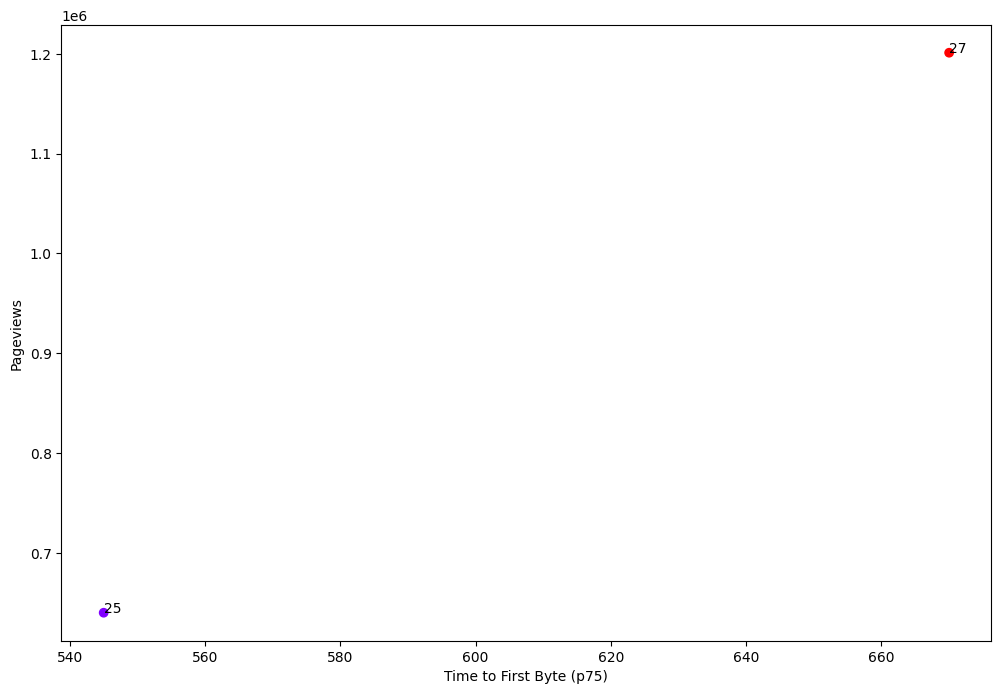

In [105]:
draw_plot(
    x_axis=cluster_aggregates["experimental_time_to_first_byte_p75"],
    x_label="Time to First Byte (p75)",
    y_axis=cluster_aggregates["pageviews"],
    y_label="Pageviews",
    data_label=cluster_aggregates["cluster"],
    filter=cluster_aggregates["experimental_time_to_first_byte_p75"] > 500,
)

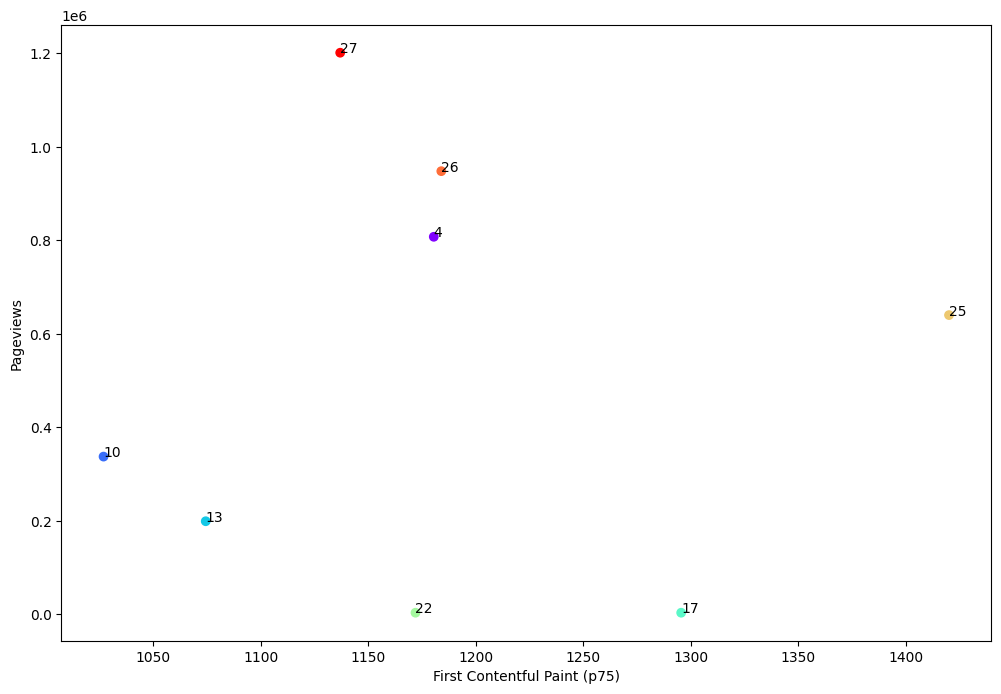

In [106]:
draw_plot(
    x_axis=cluster_aggregates["first_contentful_paint_p75"],
    x_label="First Contentful Paint (p75)",
    y_axis=cluster_aggregates["pageviews"],
    y_label="Pageviews",
    data_label=cluster_aggregates["cluster"],
    filter=cluster_aggregates["first_contentful_paint_p75"] > 1000,
)

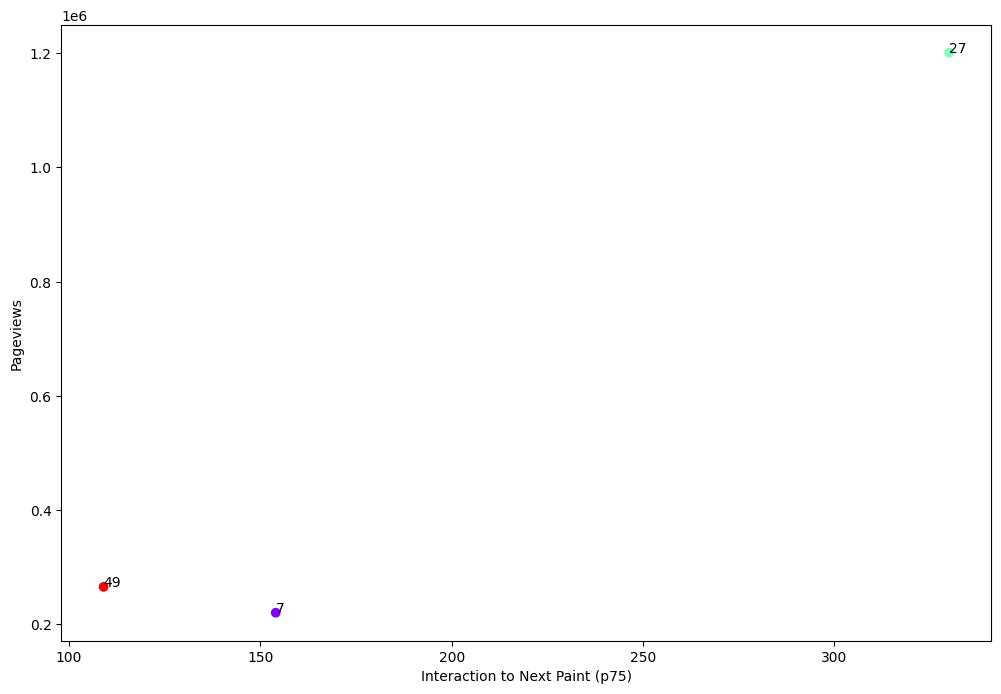

In [107]:
draw_plot(
    x_axis=cluster_aggregates["interaction_to_next_paint_p75"],
    x_label="Interaction to Next Paint (p75)",
    y_axis=cluster_aggregates["pageviews"],
    y_label="Pageviews",
    data_label=cluster_aggregates["cluster"],
    filter=cluster_aggregates["interaction_to_next_paint_p75"] > 100,
)

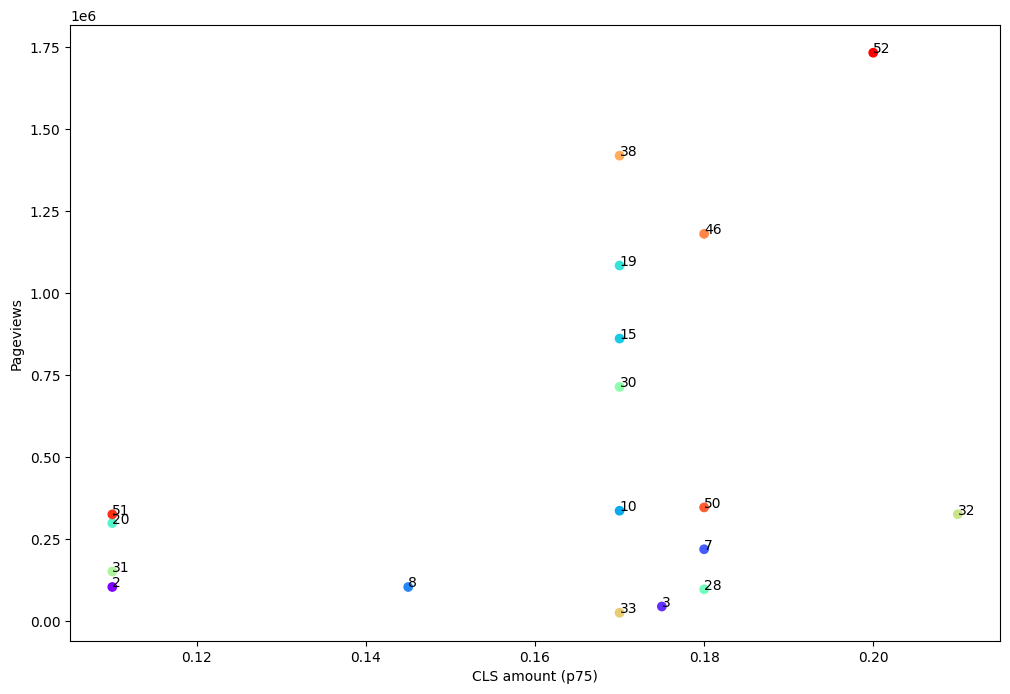

In [108]:
draw_plot(
    x_axis=cluster_aggregates["cumulative_layout_shift_p75"],
    x_label="CLS amount (p75)",
    y_axis=cluster_aggregates["pageviews"],
    y_label="Pageviews",
    data_label=cluster_aggregates["cluster"],
    filter=cluster_aggregates["cumulative_layout_shift_p75"] > 0.08,
)

In [109]:
examine = merged_df[merged_df["cluster"] == 27]

examine.head(5000)

,page_title,domain,pagePath,pageviews,url,cluster,experimental_time_to_first_byte_p75,experimental_time_to_first_byte_good_density,experimental_time_to_first_byte_needs_improvement_density,experimental_time_to_first_byte_poor_density,...,largest_contentful_paint_needs_improvement_density,largest_contentful_paint_poor_density,cumulative_layout_shift_p75,cumulative_layout_shift_good_density,cumulative_layout_shift_needs_improvement_density,cumulative_layout_shift_poor_density,interaction_to_next_paint_p75,interaction_to_next_paint_good_density,interaction_to_next_paint_needs_improvement_density,interaction_to_next_paint_poor_density
10,Search For Soldiers - The Civil War (U.S. National Park Service),www.nps.gov,/civilwar/search-soldiers.htm,233394,https://www.nps.gov/civilwar/search-soldiers.htm,27,300.0,0.9362,0.0418,0.0220,...,0.0127,0.0135,0.05,0.8066,0.0575,0.1359,144.0,0.8518,0.1167,0.0315
11,Search For Soldiers - The Civil War (U.S. National Park Service),www.nps.gov,/civilwar/search-soldiers.htm,233394,https://www.nps.gov/civilwar/search-soldiers.htm,27,300.0,0.9362,0.0418,0.0220,...,0.0127,0.0135,0.05,0.8066,0.0575,0.1359,144.0,0.8518,0.1167,0.0315
44,Advanced Search (U.S. National Park Service),www.nps.gov,/findapark/advanced-search.htm,125289,https://www.nps.gov/findapark/advanced-search.htm,27,252.0,0.9372,0.0498,0.0130,...,0.0078,0.0070,0.00,0.9775,0.0036,0.0189,97.0,0.9334,0.0552,0.0114
45,Advanced Search (U.S. National Park Service),www.nps.gov,/findapark/advanced-search.htm,125289,https://www.nps.gov/findapark/advanced-search.htm,27,252.0,0.9372,0.0498,0.0130,...,0.0078,0.0070,0.00,0.9775,0.0036,0.0189,97.0,0.9334,0.0552,0.0114
106,Multimedia Search (U.S. National Park Service),www.nps.gov,/media/multimedia-search.htm,65300,https://www.nps.gov/media/multimedia-search.htm,27,153.0,0.9511,0.0286,0.0203,...,0.0169,0.0109,0.08,0.7560,0.0319,0.2122,101.0,0.9383,0.0443,0.0174
107,Multimedia Search (U.S. National Park Service),www.nps.gov,/media/multimedia-search.htm,65300,https://www.nps.gov/media/multimedia-search.htm,27,153.0,0.9511,0.0286,0.0203,...,0.0169,0.0109,0.08,0.7560,0.0319,0.2122,101.0,0.9383,0.0443,0.0174
108,Search For Battle Units - The Civil War (U.S. National Park Service),www.nps.gov,/civilwar/search-battle-units.htm,65085,https://www.nps.gov/civilwar/search-battle-units.htm,27,280.0,0.9628,0.0235,0.0137,...,0.0102,0.0076,0.08,0.7520,0.0677,0.1804,130.0,0.8775,0.0897,0.0328
109,Search For Battle Units - The Civil War (U.S. National Park Service),www.nps.gov,/civilwar/search-battle-units.htm,65085,https://www.nps.gov/civilwar/search-battle-units.htm,27,280.0,0.9628,0.0235,0.0137,...,0.0102,0.0076,0.08,0.7520,0.0677,0.1804,130.0,0.8775,0.0897,0.0328
151,Article Search (U.S. National Park Service),www.nps.gov,/media/article-search.htm,51752,https://www.nps.gov/media/article-search.htm,27,315.0,0.9227,0.0527,0.0245,...,0.0327,0.0260,0.46,0.5688,0.0251,0.4062,130.0,0.8723,0.0947,0.0330
175,Battle Unit Details - The Civil War (U.S. National Park Service),www.nps.gov,/civilwar/search-battle-units-detail.htm,43491,https://www.nps.gov/civilwar/search-battle-units-detail.htm,27,742.0,0.7821,0.1837,0.0343,...,0.0483,0.0199,0.00,0.9917,0.0064,0.0019,63.0,0.9745,0.0109,0.0146
